In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# 读取数据
data = pd.read_excel('./data/清洗数据-0714.xlsx')
data = data[data['年龄']>60]
# X, y = make_classification(n_samples=1000, n_classes=2, random_state=20)

In [3]:
dingliang_set = {"舒张压", "收缩压", "LDL-C检测值", "HDL-C检测值", "空腹血糖检测值", "最高值肌酐检测值", 
                  "首次血红蛋白检测值", "CK-MB最高值检测值","肌钙蛋白T最高值检测值","肌红蛋白最高值检测值",
                  "BNP检测值","NT-proBNP检测值","LVEF","乳酸脱氢酶最高值检测值.2","TyG指数","TG/HDL"}
dingxing_set = {"脑血管病史", "合并糖尿病", "室壁瘤.1", "附壁血栓", "室壁瘤", "其他出血事件", "首次心功能分级", 
                 "LM_LAD_LCX_RCA"}
total_element = dingliang_set.union(dingxing_set)
element_size = len(total_element)

# sub_set = ["舒张压", "收缩压", "LDL-C检测值", "HDL-C检测值", "空腹血糖检测值", "最高值肌酐检测值", 
#           "首次血红蛋白检测值", "CK-MB最高值检测值","肌钙蛋白T最高值检测值","肌红蛋白最高值检测值",
#           "BNP检测值","NT-proBNP检测值","LVEF","乳酸脱氢酶最高值检测值.2","TyG指数","TG/HDL",
#            # 定性分析
#           "脑血管病史", "合并糖尿病", "附壁血栓", "室壁瘤", "其他出血事件", "首次心功能分级", 
#           "LM_LAD_LCX_RCA"]
sub_set = ["肌红蛋白最高值检测值","TyG指数","TG/HDL","LVEF",
           "合并糖尿病","收缩压","LDL-C检测值","TG检测值","空腹血糖检测值",
           "首次血红蛋白检测值","CK-MB最高值检测值","肌钙蛋白I最高值检测值","HDL-C检测值",
           # 定性分析 "HDL-C检测值", "肌钙蛋白T最高值检测值","室壁瘤","附壁血栓",  "其他出血事件", 
          "脑血管病史",  "首次心功能分级", 
          "LM_LAD_LCX_RCA"]
# sub_set = ['TG/HDL', 'LM_LAD_LCX_RCA', '舒张压', '首次心功能分级', 'CK-MB最高值检测值', 'LVEF']
multi_logi_df = data[sub_set]


# 定性分析
multi_logi_df['脑血管病史'] = multi_logi_df['脑血管病史'].apply(lambda x: 1 if x == "是" else 0)
multi_logi_df['合并糖尿病'] = multi_logi_df['合并糖尿病'].apply(lambda x: 1 if x == True else 0)
# multi_logi_df['附壁血栓'] = multi_logi_df['附壁血栓'].apply(lambda x: 1 if x == "是" else 0)
# multi_logi_df['室壁瘤'] = multi_logi_df['室壁瘤'].apply(lambda x: 1 if x == "是"  else 0)
# multi_logi_df['其他出血事件'] = multi_logi_df['其他出血事件'].apply(lambda x: 1 if x == "是" else 0)
multi_logi_df['首次心功能分级'] = multi_logi_df['首次心功能分级'].apply(lambda x: 1 if x!= "Ⅰ级" else 0)
multi_logi_df['LM_LAD_LCX_RCA'] = multi_logi_df['LM_LAD_LCX_RCA'].apply(lambda x: 1 if x != "单支" else 0)



# 定量分析
for col_name in multi_logi_df.columns:
    if col_name in sub_set:
        # print(col_name)
        multi_logi_df[col_name] = multi_logi_df[col_name].fillna(value=multi_logi_df[col_name].mean())
        
multi_logi_df = multi_logi_df.rename(
    {
     "合并糖尿病":"糖尿病",
     "脑血管病史":"脑血管病",  
     "收缩压":"收缩压",
     "LDL-C检测值":"LDL-C",
     "TG检测值":"TG",
     "空腹血糖检测值":"FBG",
     "首次血红蛋白检测值":"Hb",
     "CK-MB最高值检测值":"CK-MB",
     "肌钙蛋白I最高值检测值":"肌钙蛋白I",
     "肌红蛋白最高值检测值":"MYO",
     "BNP检测值":"BNP",
     "TyG指数":"TyG指数",
     "TG/HDL":"TG/HDL",
     "LVEF":"LVEF(%)",
     "首次心功能分级":"Killip分级", 
      "LM_LAD_LCX_RCA":"血管病变",
        
        
    "肌钙蛋白T最高值检测值":"肌钙蛋白T",
     "HDL-C检测值":"HDL-C",
           # 定性分析
     "附壁血栓":"附壁血栓", 
     "室壁瘤":"室壁瘤", 
     "其他出血事件":"其他出血事件" },axis=1)
        
data_Y = data['mace']
train_X,test_X,train_y,test_y = train_test_split(multi_logi_df,data_Y,test_size=0.3,random_state=5)
mm = MinMaxScaler() 
train_data_m = mm.fit_transform(train_X) #注意fit_transform() 和 transform()的区别 用同一套归一化参数
test_data_m = mm.transform(test_X) 

/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/88992058.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_logi_df['脑血管病史'] = multi_logi_df['脑血管病史'].apply(lambda x: 1 if x == "是" else 0)
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/88992058.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_logi_df['合并糖尿病'] = multi_logi_df['合并糖尿病'].apply(lambda x: 1 if x == True else 0)
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/88992058.py:31: Sett

/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/1528543721.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/1528543721.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/1528543721.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/1528543721.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/var/folders/6y/2k_kxtyd07v79br33f6gvjn00000gn/T/ipykernel_24454/152

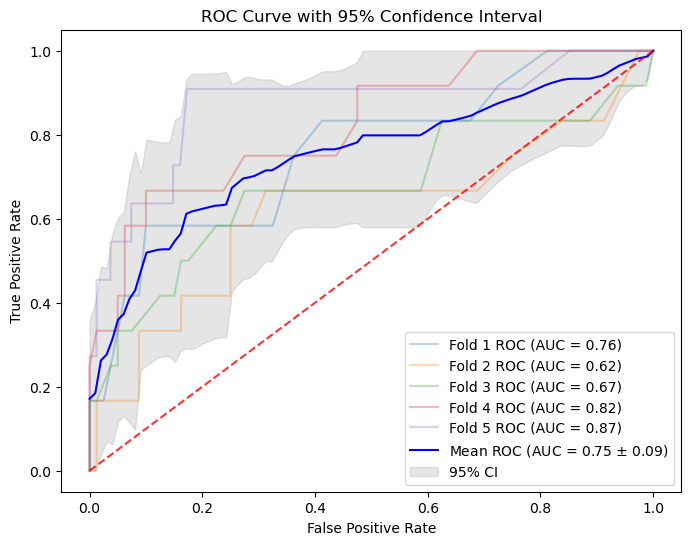

In [4]:
# 模型
classifier = RandomForestClassifier(random_state=20)

# 使用StratifiedKFold进行交叉验证
cv = StratifiedKFold(n_splits=5)

# 存储结果
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(multi_logi_df, data_Y)):
    classifier.fit(multi_logi_df.iloc[train], data_Y.iloc[train])
    probas_ = classifier.predict_proba(multi_logi_df.iloc[test])
    fpr, tpr, thresholds = roc_curve(data_Y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} ROC (AUC = {roc_auc:.2f})')

# 计算平均ROC曲线
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

# 计算置信区间
tprs_upper = np.minimum(mean_tpr + 1.96 * np.std(tprs, axis=0), 1)
tprs_lower = np.maximum(mean_tpr - 1.96 * np.std(tprs, axis=0), 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'95% CI')

# 图形美化
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 95% Confidence Interval')
plt.legend(loc="lower right")
plt.show()

In [15]:
multi_logi_df.iloc[[1,2]]

,MYO,TyG指数,TG/HDL,LVEF(%),糖尿病,收缩压,LDL-C,TG,FBG,Hb,CK-MB,肌钙蛋白I,HDL-C,脑血管病,Killip分级,血管病变
1,427.249135,0.857935,2.901408,58.0,1,190,3.05,2.06,7.00,145.0,9.0,0.009,0.71,0,1,0
3,427.249135,0.461679,1.076923,42.0,0,120,2.19,1.12,5.17,54.0,58.4,26.930,1.04,1,1,0


In [17]:
data_Y

0        True
1        True
3        True
4        True
8        True
        ...  
1120    False
1121    False
1129    False
1131    False
1132    False
Name: mace, Length: 460, dtype: bool